In [ ]:
!pip install pycaret
!pip install markupsafe==2.0.1


NOW MUST RESTART RUNTIME

In [ ]:
!pip install imblearn --ignore-installed

In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 29.1 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score, r2_score, mean_squared_error
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTENC
import shap

import matplotlib.pyplot as plt
import seaborn as sns

The dataset is coming from kaggle:

https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

Description:

You are owing a supermarket mall and through membership cards , you have some basic data about your customers like Customer ID, age, gender, annual income and spending score. 
Spending Score is something you assign to the customer based on your defined parameters like customer behavior and purchasing data.

Problem Statement:

You own the mall and want to understand who are the customers with a high spending score to optimize the marketing strategy.


In [5]:
df = pd.read_csv('/content/drive/MyDrive/AppliedMachineLearning/Miniproject/Data/Mall_Customers.csv')

In [6]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
df1=df.rename(columns = {'Annual Income (k$)':'income','Spending Score (1-100)':'score' })
df1.set_index("CustomerID",inplace=True)


In [8]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
# Instead keep the Gender as is and make it and additional step before modelling to LabelEncode it into 2 new columns.
#df1['Gender']= df1['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
#df1.head()

Lets plot the numeric features distribution

In [12]:
numeric_features = df1.select_dtypes(include=['int', 'float']).columns.tolist()

numeric_features

['Age', 'income', 'score']

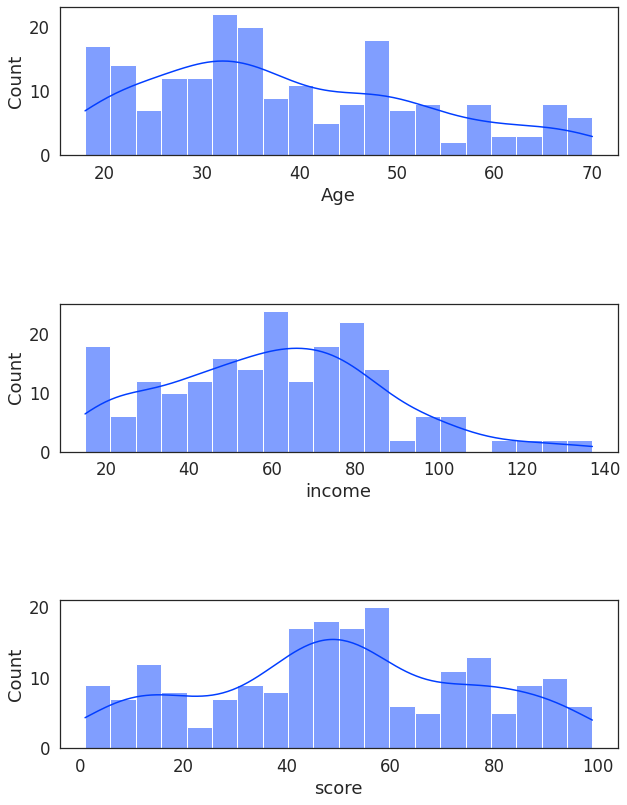

In [13]:
i = 1
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("bright")
plt.figure(figsize=(10, 30))
plt.subplots_adjust(hspace=1)
for feature in numeric_features:
    plt.subplot(6,1,i)
    sns.histplot(df1[feature], kde = True, bins = 20)
    i = i +1

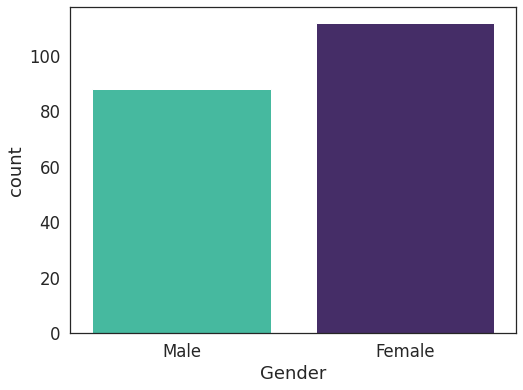

In [17]:
plt.figure(figsize=(8,6))
p = sns.countplot(x='Gender',data=df1, palette=['#33ccaa','#432371'])

The dataset consists of similar number of female (0) and male(1) customers, but there is a bit more female.


Lets look now at correlation between the numeric features in both genders.

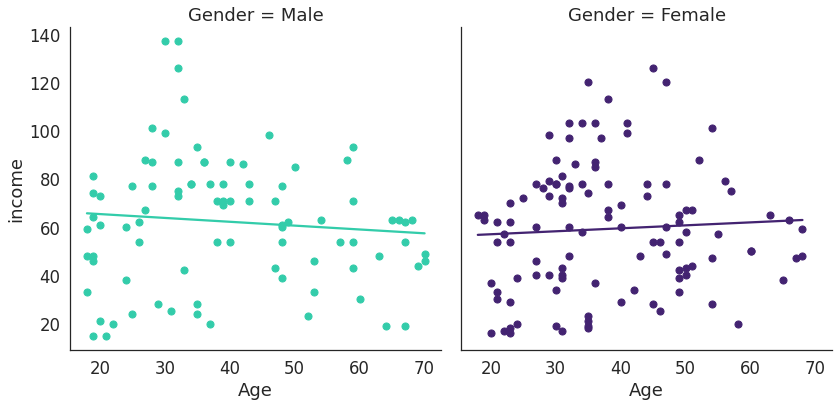

In [18]:
_ = sns.lmplot(x="Age", y="income", col="Gender", hue="Gender", data=df1,
            col_wrap=2, ci=None, palette=['#33ccaa','#432371'], height=6,
            scatter_kws={"s": 50, "alpha": 1})

It seems like income is not dependend on age in this dataset.

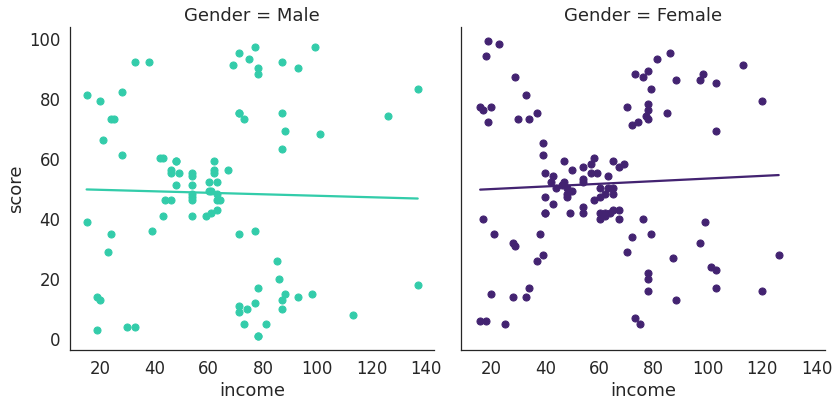

In [19]:
_ =sns.lmplot(x="income", y="score", col="Gender", hue="Gender", data=df1,
            col_wrap=2, ci=None, palette=['#33ccaa','#432371'], height=6,
            scatter_kws={"s": 50, "alpha": 1})

Interestingly it does not seem like income and spending score are correlated. It seems like there are some clusters in this plot. I will explore it more later after clustering.


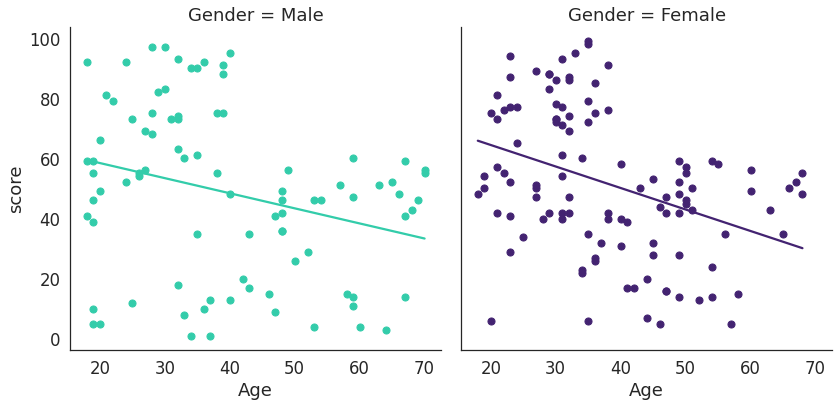

In [20]:
_ =sns.lmplot(x="Age", y="score", col="Gender", hue="Gender", data=df1,
            col_wrap=2, ci=None, palette=['#33ccaa','#432371'], height=6,
            scatter_kws={"s": 50, "alpha": 1})

Here we can see a correlation between a spending score and age of customers - younger customers are spending more. I will continue now with clustering.

Let's first change the categorical values to 1/0 with label encoder.

In [23]:
categorical_features = df1.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features

['Gender']

In [28]:
from re import I
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
for i in categorical_features:
  df1[f'{i}'] = labelencoder.fit_transform(df1[f'{i}'])
df1

,Gender,Age,income,score
CustomerID,,,,
1,1,19,15,39
2,1,21,15,81
3,0,20,16,6
4,0,23,16,77
5,0,31,17,40
...,...,...,...,...
196,0,35,120,79
197,0,45,126,28
198,1,32,126,74


Method 1: Choosing the optimal K in K-means: The Silhouette Method

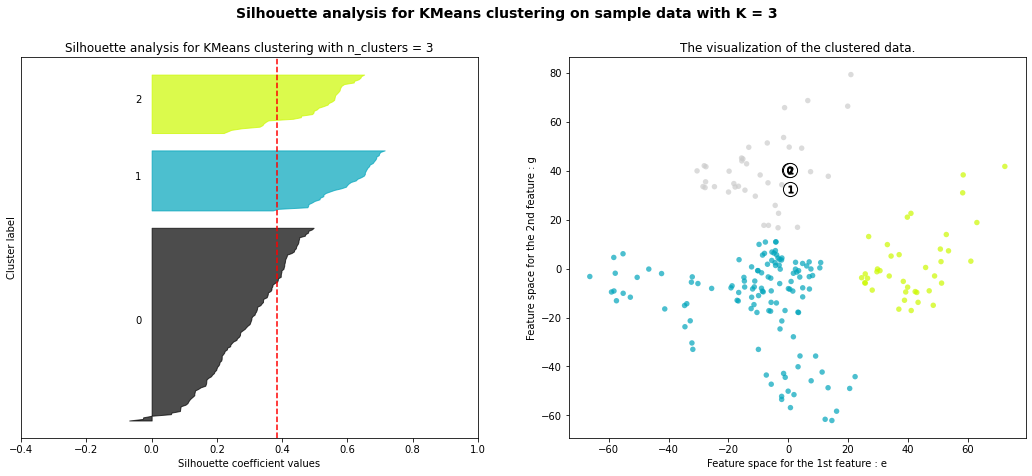

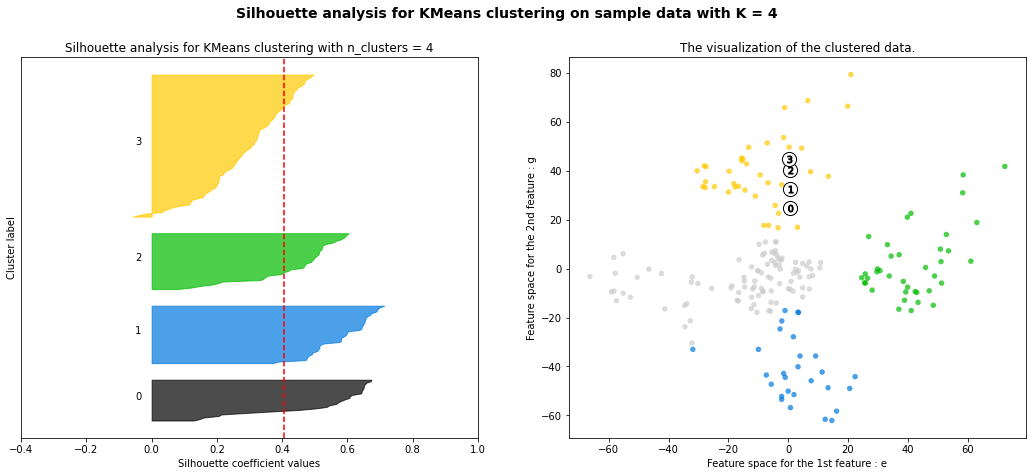

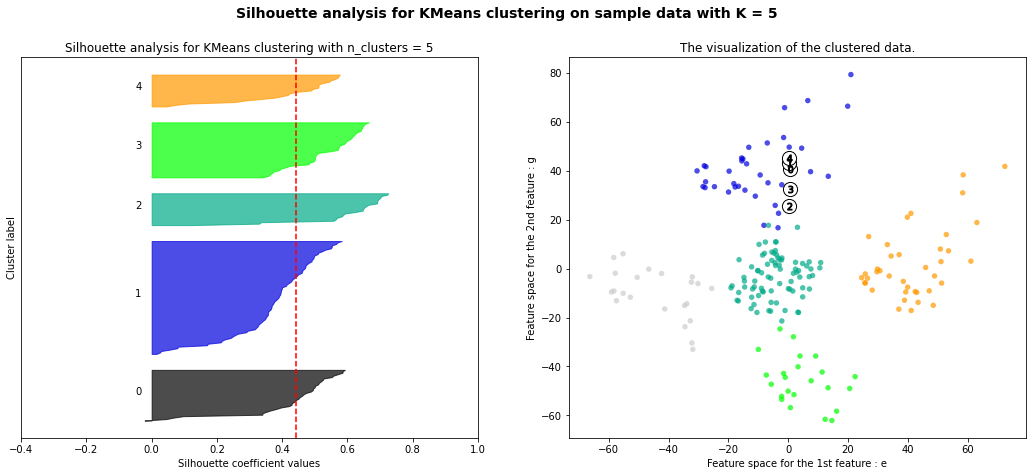

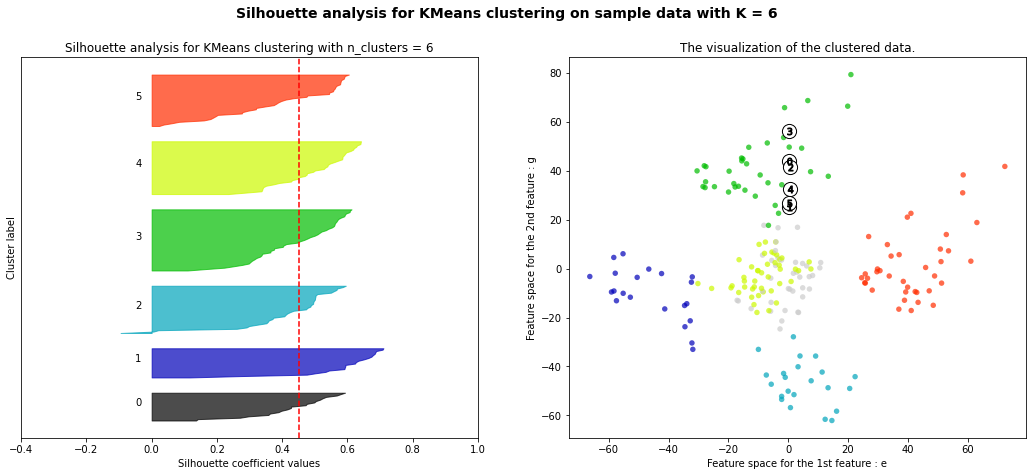

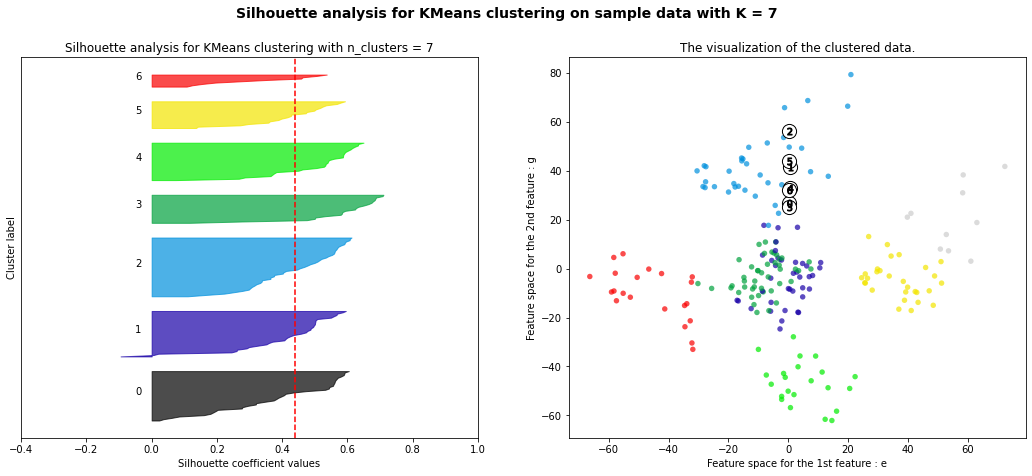

In [ ]:
# Code adapted from scikit-learn documentation example.


avg_silhouette_scores = []
cluster_ranges = range(3, 8)

# Get rid of warning of too many plots open
plt.rcParams.update({'figure.max_open_warning': 0})

for K in cluster_ranges:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    ax.set_xlim([-.4, 1])
    # The (K+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(df1) + (K + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    kmeans_model = KMeans(n_clusters=K, 
                          n_init=1000, 
                          max_iter=10000, 
                          random_state=42)
    cluster_labels = kmeans_model.fit_predict(df1)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = (silhouette_score(df1, cluster_labels))
    avg_silhouette_scores.append(silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df1, cluster_labels)

    y_lower = 10
    for i in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(f"Silhouette analysis for KMeans clustering with n_clusters = {K}")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels.astype(float) + 1) / K)
    # to visualize the actual data in a continuous space we use PCA
    pca = PCA(n_components=2).fit(df1)
    data2D = pca.transform(df1)
    ax2.scatter(data2D[:, 0], data2D[:, 1], marker='o', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans_model.cluster_centers_
    # Draw white circles at cluster centers


    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel(f"Feature space for the 1st feature : {df1.columns[0][1]}")
    ax2.set_ylabel(f"Feature space for the 2nd feature : {df1.columns[1][1]}")

    plt.suptitle(
        (
            f"Silhouette analysis for KMeans clustering on sample data with K = {K}"
        ),
        fontsize=14,
        fontweight="bold",
    )
print("\n")
 
plt.show()

5 clusters allow nice separation of the data, no negative coefifcient values. 

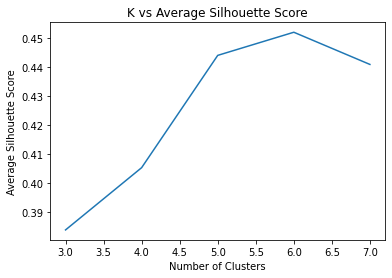

In [ ]:
ax = sns.lineplot(x=cluster_ranges, y=avg_silhouette_scores)
ax.set_title('K vs Average Silhouette Score')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Average Silhouette Score');

Score almost tops out at 5 clusters and does not increase furhter with more.

Method 2: Choosing the optimal K in K-means: The Elbow Sum-of-Squares Method

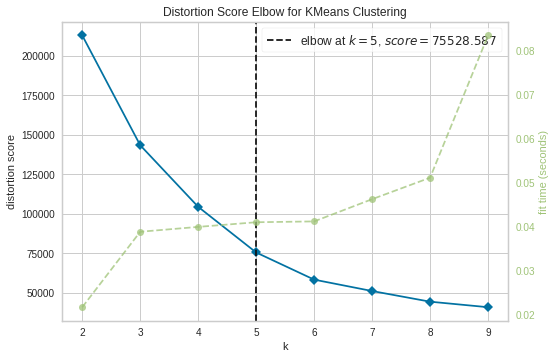

In [ ]:
from yellowbrick.cluster.elbow import kelbow_visualizer
kmeans4 = KMeans(n_clusters=4)
kv = kelbow_visualizer(kmeans4, df1, k=(2,10)) 

This analysis also points out towards 5 clusters as an optimal choice. I will proceed this way.


In [39]:
kmeans5 = KMeans(n_clusters=5, random_state=247, verbose=0)
kmeans5.fit(df1)
pred_5 = kmeans5.fit_predict(df1)
df_pred5 = df1.copy()
df_pred5['Class'] = pred_5

In [40]:
df_pred5['Class'].value_counts()

0    79
2    39
1    37
4    23
3    22
Name: Class, dtype: int64

In [41]:
# t-SNE
from sklearn.manifold import TSNE
import time 
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500, random_state=247)
tsne_results = tsne.fit_transform(df1)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 19.740422
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.905441
[t-SNE] KL divergence after 500 iterations: 0.192892
t-SNE done! Time elapsed: 6.8786303997039795 seconds


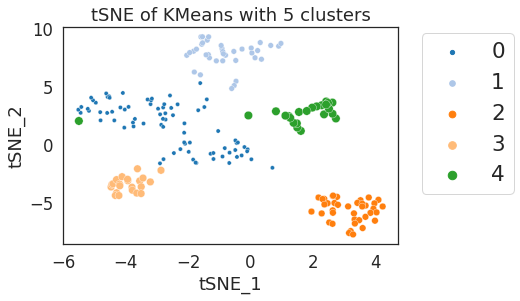

In [42]:
data_tsne = df1.copy()
data_tsne['tsne-2d-one'] = tsne_results[:,0]
data_tsne['tsne-2d-two'] = tsne_results[:,1]

df_tsne_features = pd.DataFrame({'cluster_id':df_pred5['Class'], 
                                'tsne_1':data_tsne['tsne-2d-one'], 
                                'tsne_2':data_tsne['tsne-2d-two']})
ax = sns.scatterplot(x='tsne_1', y='tsne_2', 
                hue='cluster_id', 
                size='cluster_id', 
                data=df_tsne_features, 
                palette='tab20', 
                legend='full')
ax.set_xlabel('tSNE_1')
ax.set_ylabel('tSNE_2')
ax.set_title('tSNE of KMeans with ' + str(5) + ' clusters')
ax.legend(bbox_to_anchor=(1.04,1.02), loc='upper left', fontsize='large');

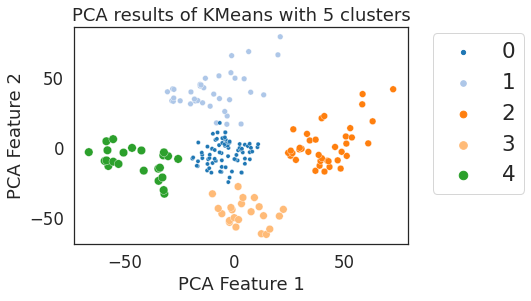

In [43]:
# PCA plot
pca = PCA(n_components=2,random_state=247 ).fit(df1)
pca_features = pca.transform(df1)
pca_x = pca_features[:, 0]
pca_y = pca_features[:, 1]

df_pca_features = pd.DataFrame({'cluster_id':df_pred5['Class'], 
                                'pc_1':pca_x, 
                                'pc_2':pca_y})
ax = sns.scatterplot(x='pc_1', y='pc_2', 
                hue='cluster_id', 
                size='cluster_id', 
                data=df_pca_features, 
                palette='tab20', 
                legend='full')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_title('PCA results of KMeans with ' + str(5) + ' clusters')
ax.legend(bbox_to_anchor=(1.04,1.02), loc='upper left', fontsize='large');

We can see the clustering was succesful and the clusters separate quite well from each other in tSNA and PCA visualizations. I will now take a look at the Score and Income scatter plot with clusters as coloring.

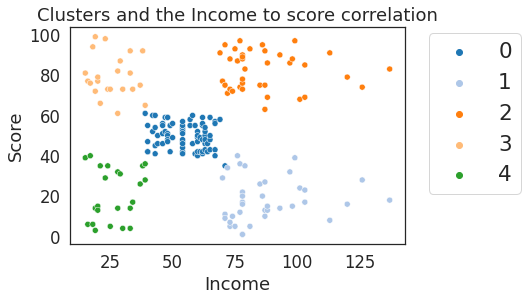

In [44]:
ax = sns.scatterplot(x='income', y='score', 
                hue=df_pca_features.cluster_id, 
                #size='cluster_id', 
                data=df1, 
                palette='tab20', 
                legend='full')
ax.set_xlabel('Income')
ax.set_ylabel('Score')
ax.set_title('Clusters and the Income to score correlation')
ax.legend(bbox_to_anchor=(1.04,1.02), loc='upper left', fontsize='large');

We can appreciate that among 5 clusters, cluster 0 and 4 clearly separate from the others in terms of the spending score. Below I will assign these high spending clusters a 1 and the other 3 clusters will have a topscore value 0.

In [45]:

df_pred5['topscore']= df_pred5['Class'].apply(lambda x: 1 if x in [2,3] else 0)

In [46]:
df_pred5.head()

,Gender,Age,income,score,Class,topscore
CustomerID,,,,,,
1,1,19,15,39,4,0
2,1,21,15,81,3,1
3,0,20,16,6,4,0
4,0,23,16,77,3,1
5,0,31,17,40,4,0


In [47]:
df_pred5['topscore'].value_counts()

0    139
1     61
Name: topscore, dtype: int64

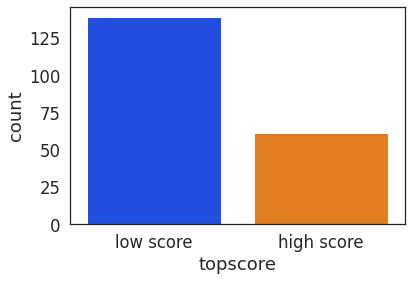

In [48]:
g = sns.countplot(df_pred5['topscore'])
g.set_xticklabels(['low score','high score'])
plt.show()

We are dealing with an imbalance in the target variable. I will try to adress it later with SMOTE rebalancing. 

In [49]:
df_clear = df_pred5.copy()
df_clear.drop(columns=['score', 'Class'], inplace = True)
df_clear.head()

,Gender,Age,income,topscore
CustomerID,,,,
1,1,19,15,0
2,1,21,15,1
3,0,20,16,0
4,0,23,16,1
5,0,31,17,0


I will first work with AutoML library PyCaret to get a quick inital idea of how different models perform with the dataset.

In [ ]:
from pycaret.classification import *

In [ ]:
grid = setup(data = df_clear, target = "topscore", session_id = 247, html = True, use_gpu = True, silent = True, verbose = True,
             experiment_name = "Miniproject_Pycaret_Value_classification", remove_outliers = True, fix_imbalance = True)

,Description,Value
0,session_id,247
1,Target,topscore
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(200, 4)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
best = compare_models(n_select=5,sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8418,0.9042,0.780,0.7639,0.7363,0.6276,0.6541,0.090
lightgbm,Light Gradient Boosting Machine,0.8264,0.8881,0.785,0.7230,0.7310,0.6057,0.6277,0.046
knn,K Neighbors Classifier,0.7956,0.8681,0.855,0.6510,0.7252,0.5705,0.6018,0.199
qda,Quadratic Discriminant Analysis,0.7808,0.8506,0.830,0.6277,0.7097,0.5407,0.5611,0.017
et,Extra Trees Classifier,0.8033,0.8139,0.760,0.6775,0.7034,0.5587,0.5744,1.011
rf,Random Forest Classifier,0.7962,0.8550,0.740,0.6675,0.6891,0.5403,0.5548,1.009
ada,Ada Boost Classifier,0.8038,0.8533,0.785,0.6162,0.6847,0.5497,0.5599,0.113
nb,Naive Bayes,0.7357,0.8172,0.855,0.5453,0.6628,0.4582,0.4995,0.017
dt,Decision Tree Classifier,0.7967,0.7617,0.690,0.6450,0.6504,0.5146,0.5239,0.019
lr,Logistic Regression,0.7055,0.7456,0.760,0.5317,0.6186,0.3911,0.4165,0.035


Quick check with AutoML library PyCaret gives us already an idea of what performance we may get. I will continue with Gradient Boosting Classifier.

In [50]:
X = df_clear.drop(columns=['topscore'])
y = df_clear['topscore']

First lets try without balancing for the target variable.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=247, stratify=y)
X_train.shape, X_test.shape

((150, 3), (50, 3))

In [52]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=247)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

class_labels = xgb.classes_

print(classification_report(y_test, y_pred))

pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

           0       0.97      0.86      0.91        35
           1       0.74      0.93      0.82        15

    accuracy                           0.88        50
   macro avg       0.85      0.90      0.87        50
weighted avg       0.90      0.88      0.88        50



,0,1
0,30,5
1,1,14


That looks pretty good. Now lets compare it with SMOTE - prebalanced approach.



In [53]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 140 to 100
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Gender  150 non-null    int64
 1   Age     150 non-null    int64
 2   income  150 non-null    int64
dtypes: int64(3)
memory usage: 4.7 KB


In [54]:
smtnc = SMOTENC(categorical_features=[0]) # initialize the SMOTENC object
X_train_smote, y_train_smote = smtnc.fit_resample(X_train, y_train) 
X_train_smote.shape

(208, 3)

In [55]:
y_train_smote.value_counts()

1    104
0    104
Name: topscore, dtype: int64

In [56]:
xgb.fit(X_train_smote, y_train_smote)
y_pred = xgb.predict(X_test)

class_labels = xgb.classes_

print(classification_report(y_test, y_pred))

pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        35
           1       0.78      0.93      0.85        15

    accuracy                           0.90        50
   macro avg       0.87      0.91      0.89        50
weighted avg       0.91      0.90      0.90        50



,0,1
0,31,4
1,1,14


Rebalancing actually slightly decresed the performance. I will now try to optimize the hyperparameters of the model.


In [ ]:
# First do here RandomSearch

In [72]:
from sklearn.model_selection import RandomizedSearchCV
rand_search = {'max_depth': [5,10, 20, 30,40],
                 'learning_rate': [0.05,0.1, 0.2, 0.3, 0.4],
                 'n_estimators': [25, 50, 100, 200, 300]}

rand_search_obj = RandomizedSearchCV(estimator=xgb, 
                               param_distributions=rand_search,
                               scoring='f1', n_iter=20,cv = 20, random_state = 247)

rand_search_obj.fit(X_train_smote, y_train_smote)


RandomizedSearchCV(cv=20, estimator=XGBClassifier(random_state=247), n_iter=20,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.4],
                                        'max_depth': [5, 10, 20, 30, 40],
                                        'n_estimators': [25, 50, 100, 200,
                                                         300]},
                   random_state=247, scoring='f1')

In [73]:
rand_search_obj.best_params_

{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 25}

In [74]:
from sklearn.model_selection import GridSearchCV

grid_search = {'max_depth': [5,10, 20],
                 'learning_rate': [0.1,0.2, 0.3],
                 'n_estimators': [25, 50, 100]}

grid_search_obj = GridSearchCV(estimator=xgb, 
                               param_grid=grid_search,
                               scoring='f1',cv = 20)

grid_search_obj.fit(X_train_smote, y_train_smote)



GridSearchCV(cv=20, estimator=XGBClassifier(random_state=247),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [5, 10, 20],
                         'n_estimators': [25, 50, 100]},
             scoring='f1')

What are the best parameters?

In [75]:
grid_search_obj.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}

I will now create the final model, fit it to the training data and predict the target variable.

In [76]:
final_xgb = XGBClassifier(learning_rate =  0.1, max_depth =  5, n_estimators = 50, random_state=247)

In [77]:
final_xgb.fit(X_train_smote, y_train_smote)
y_pred = final_xgb.predict(X_test)

Lets create a confusion matrix as a summary

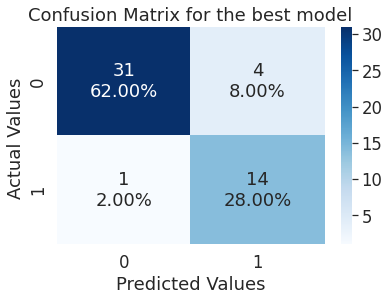

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        35
           1       0.78      0.93      0.85        15

    accuracy                           0.90        50
   macro avg       0.87      0.91      0.89        50
weighted avg       0.91      0.90      0.90        50



In [78]:

cf_matrix = confusion_matrix(y_test, y_pred)

#print(cf_matrix)

#group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix for the best model');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()
print(classification_report(y_test, y_pred))

On avarage 93% of clients with a low spending score and 85% of clients with a high spending score are correctly predicted by the model. Since we deal here with an imbalanced dataset it is important to track the F1 score - a harmonic mean betweeen precision and recall - which is good enough in this situation. 

Let's explore the model explainability and feature importances with help of SHAP

In [79]:
explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer.shap_values(X_test)

What are the feature importances assesed by SHAP?

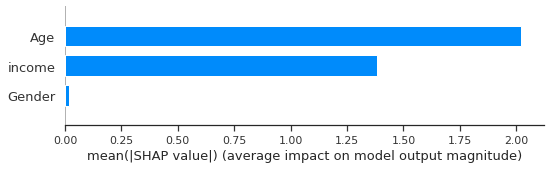

In [80]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

An example for client with a low spending score:


In [81]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[4, :], X_test.iloc[4, :])

An example for client with a high spending score

In [82]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[8, :], X_test.iloc[8, :])

The impact of Age and income on the spending score:

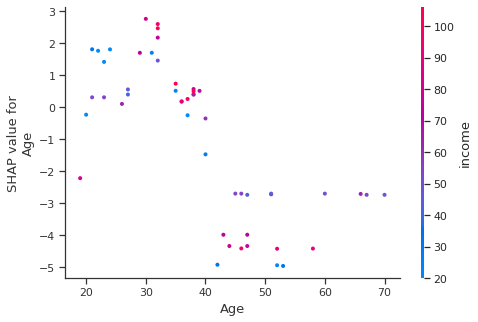

In [83]:
shap.dependence_plot(ind='Age', interaction_index='income',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

It seems like the Income and Age play the biggest role in predicting whether customer will receive a high spending score. 
+ Younger customers, below 40 years old, have a higher spending score than old customers. 
+ In addition, among old customers the high and medium income usually means higher spending score. 

With the model Shopping mole can predict whether certain client will be their customer of interest with a high spending score simply based on the Age, Income and gender. 